<a href="https://colab.research.google.com/github/SoumyaCO/reverse-image-searching/blob/main/Reverse_Image_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reverse Image Searching
Reverse Image searching is finding a similar/same image from a huge image database by querying with an image itself.

---
**Applications:**
1. Security system: The sensitive places when only the authorized persoons are allowed, there reverse image search is used to find that person from the database.
2. Amazon, Google, Printrest uses the same technology to give the user the ease of searching a thing by their image.

---
**Previous Solutions:**\
Previously traditional image detection algorithms is being used, like -
- SIFT (Scale-Invariant Feature transform)
- SURF (Speeded UP Robust Features)
- ORB (Oriented FAST and Rotated BRIEF)

---
**Automated Approach / Non-heuristic / ML approach:**\
Use Convolutional Neural networks to extract features from the images, and then trying to figure out the similar images using the clustering algorithms (Traditional ml) or later we can build an end-to-end deep learning solution for this.

Even after that we will take a look at the latest algorithms that are being used inside google, facebook and printrest 's search engines.

we'll build similar scalable reverse image search engine via simple line of codes with *keras* and tensorflow.

---
**Dataset we'll be using:**\
We'll beusing the [*caltech101*](https://www.tensorflow.org/datasets/catalog/caltech101) dataset for query.

and as image database we'll be using [*caltech256*](https://paperswithcode.com/dataset/caltech-256)


In [1]:
# download the dataset
!wget https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip
!echo "1. Caltech101 data downloaded.."
# unzip the file and get the required dataset
!unzip /content/caltech-101.zip
!echo "2. File unzipped"

!mkdir caltech101
!echo "3. Made a directory named - caltech101"
# extract the tar.gz file and delete other files.
!tar -xvf /content/caltech-101/101_ObjectCategories.tar.gz
!mv 101_ObjectCategories caltech101
!echo "4. Moved the 101_ObjectCategories dir. to caltech101"
!rm -rf __MACOSX caltech-101 caltech-101.zip
!rm -rf /content/caltech101/101_ObjectCategories/BACKGROUND_Google
!echo "5. removed unnecessary folders and files."

!echo "ALL PROCESSES COMPLETED"

Streaming output truncated to the last 5000 lines.
101_ObjectCategories/chair/image_0008.jpg
101_ObjectCategories/chair/image_0010.jpg
101_ObjectCategories/chair/image_0011.jpg
101_ObjectCategories/chair/image_0012.jpg
101_ObjectCategories/chair/image_0013.jpg
101_ObjectCategories/chair/image_0014.jpg
101_ObjectCategories/chair/image_0016.jpg
101_ObjectCategories/chair/image_0017.jpg
101_ObjectCategories/chair/image_0018.jpg
101_ObjectCategories/chair/image_0019.jpg
101_ObjectCategories/chair/image_0020.jpg
101_ObjectCategories/chair/image_0022.jpg
101_ObjectCategories/chair/image_0023.jpg
101_ObjectCategories/chair/image_0024.jpg
101_ObjectCategories/chair/image_0025.jpg
101_ObjectCategories/chair/image_0026.jpg
101_ObjectCategories/chair/image_0028.jpg
101_ObjectCategories/chair/image_0029.jpg
101_ObjectCategories/chair/image_0030.jpg
101_ObjectCategories/chair/image_0031.jpg
101_ObjectCategories/chair/image_0032.jpg
101_ObjectCategories/chair/image_0034.jpg
101_ObjectCategories/chai

In [2]:
# Import all the necessary modules
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, notebook
import os
import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

### Approach:
1. Load the resnet model without the head (classifier part) so that we just get the *bottleneck features*.
2. Define a function that loades the image path, resizes to the proper dimensions to supported by ResNet50
3. Extract the features
Normalizes them.

In [3]:
# Loading the model without the classifier part (top part)
model = ResNet50(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3), pooling='max')

# Look above code, at the end I've used pooling layer to reduce the dimension of the feature-maps
# otherwise the features for all 8000+ images are not going to fit inside the 12GB RAM (colab gives 12gb RAM)
# Don't believe me? omit the pooling layer and try it. All the best.

def extract_features(img_path, model):
  input_shape = (224, 224, 3)
  img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
  img_array = image.img_to_array(img)
  expanded_img_array = np.expand_dims(img_array, axis=0)
  preprocessed_img = preprocess_input(expanded_img_array)
  features = model.predict(preprocessed_img)
  flattened_features = features.flatten()
  normalized_features = flattened_features / norm(flattened_features)
  return normalized_features

In [4]:
features = extract_features('/content/caltech101/101_ObjectCategories/Faces/image_0001.jpg', model)
print(len(features))

1/1 [==============================] - 3s 3s/step
2048


In [5]:
features[:20]

array([0.01439906, 0.00954923, 0.00942189, 0.06149979, 0.01146759,
       0.03504059, 0.00971735, 0.00880827, 0.00844249, 0.01427105,
       0.01102419, 0.06425143, 0.        , 0.01085275, 0.00405427,
       0.00793838, 0.00475544, 0.012426  , 0.01998498, 0.0631754 ],
      dtype=float32)

As we can see feature is an array of values between the range [0, 1]

Now it's time to extract features for the entire dataset. First we getall the filenames.

In [6]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
  file_list = []
  counter = 1
  for root, directories, filenames in os.walk(root_dir):
    for filename in filenames:
      if any(ext in filename for ext in extensions):
        file_list.append(os.path.join(root, filename))
        counter += 1
  return file_list

In [7]:
# path tothe datasets
root_dir = '/content/caltech101/'
filenames=sorted(get_file_list(root_dir))
filenames[:10]

['/content/caltech101/101_ObjectCategories/Faces/image_0001.jpg',
 '/content/caltech101/101_ObjectCategories/Faces/image_0002.jpg',
 '/content/caltech101/101_ObjectCategories/Faces/image_0003.jpg',
 '/content/caltech101/101_ObjectCategories/Faces/image_0004.jpg',
 '/content/caltech101/101_ObjectCategories/Faces/image_0005.jpg',
 '/content/caltech101/101_ObjectCategories/Faces/image_0006.jpg',
 '/content/caltech101/101_ObjectCategories/Faces/image_0007.jpg',
 '/content/caltech101/101_ObjectCategories/Faces/image_0008.jpg',
 '/content/caltech101/101_ObjectCategories/Faces/image_0009.jpg',
 '/content/caltech101/101_ObjectCategories/Faces/image_0010.jpg']

In [8]:
# extract the features for all
feature_list = []
for i in notebook.tqdm(range(len(filenames))):
  feature_list.append(extract_features(filenames[i], model));

  0%|          | 0/8677 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 41ms/step


Now just same these features to a pickle file so that we can use them in the future without having to reclaculate them

In [9]:
# create a folder named data
os.mkdir('data/')

In [10]:
pickle.dump(feature_list, open('data/features-caltech101-resnet.pickle', 'wb'))
pickle.dump(filenames, open('data/filenames-caltech101.pickle', 'wb'))

That's all for the feature extraction part

### Similarity Search
Gievn a photograph, our aim is to find another photo in our dataset similar to the current one. We begin by loading the precomputed features:


In [11]:
filenames = pickle.load(open('/content/data/filenames-caltech101.pickle', 'rb'))
feature_list = pickle.load(open('/content/data/features-caltech101-resnet.pickle', 'rb'))

Now we'll use nearest neighbors of the query features to find the similar images.

In [12]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='euclidean').fit(feature_list)
distances, indices = neighbors.kneighbors([feature_list[0]])

Now you have both the indices and sistances fo the nearest neighbors (five neighbors) of the very first query feature.


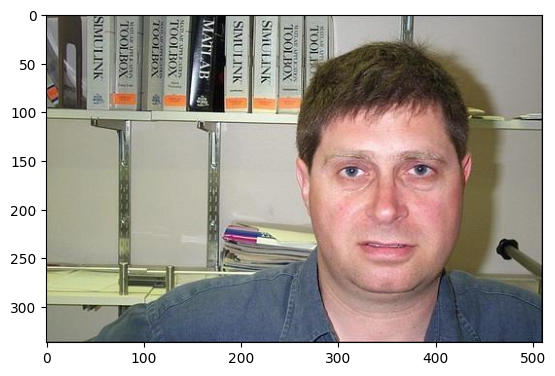

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
plt.imshow(mpimg.imread(filenames[0]))

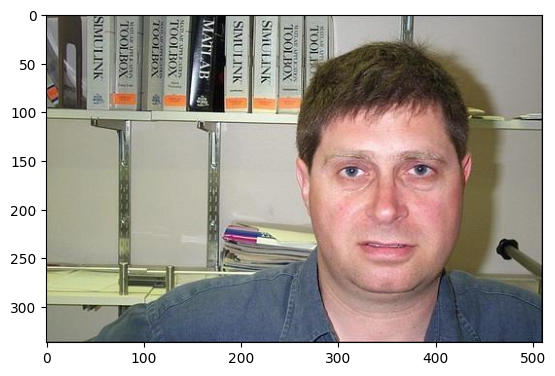

In [14]:
# Let's examine the first nearest neighbor
plt.imshow(mpimg.imread(filenames[indices[0][0]]))

In [15]:
# visualize the indices and distances
print(indices)
print('\n======================================\n')
print(distances)

[[  0 435  19 436   1]]


[[0.         0.60484668 0.60662986 0.63081799 0.63656879]]


###<font color='green'>plot_nearest_images</font> Function 👇

In [16]:
def plot_nearest_images(image_index):
  distances, indices = neighbors.kneighbors([feature_list[image_index]])
  plt.figure(figsize = (20, 6))
  for i in range(5):
    filename = filenames[indices[0][i]].split('/')[-2] + "/" + filenames[indices[0][i]].split('/')[-1]
    ax = plt.subplot(1, 5, i+1)
    ax.imshow(mpimg.imread(filenames[indices[0][i]]))
    if i == 0:
      ax.set_title(f"Original Image \n{filename} \nEuc. distance: {distances[0][i]:.2f}", fontsize = 8)
    else:
      ax.set_title(f"Similar Image \n{filename} \nEuc.Distance: {distances[0][i]:.2f}", fontsize=8)

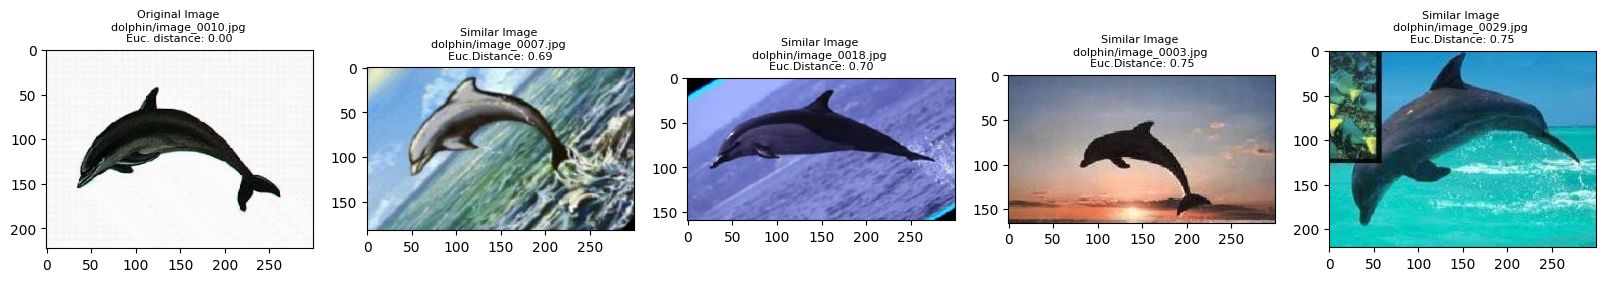

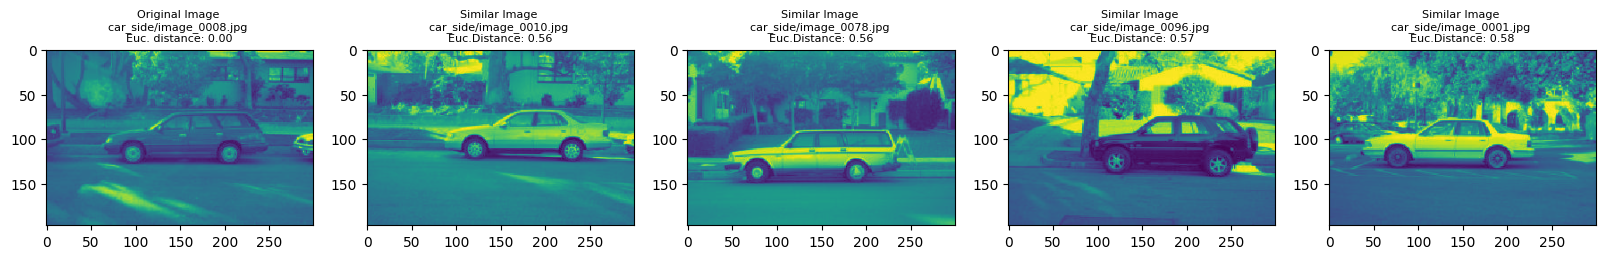

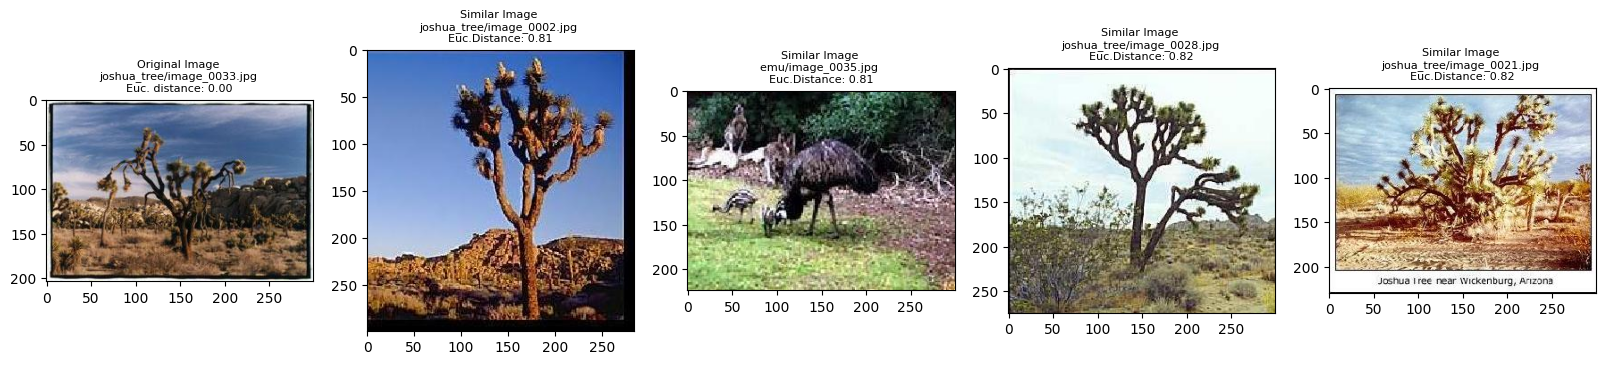

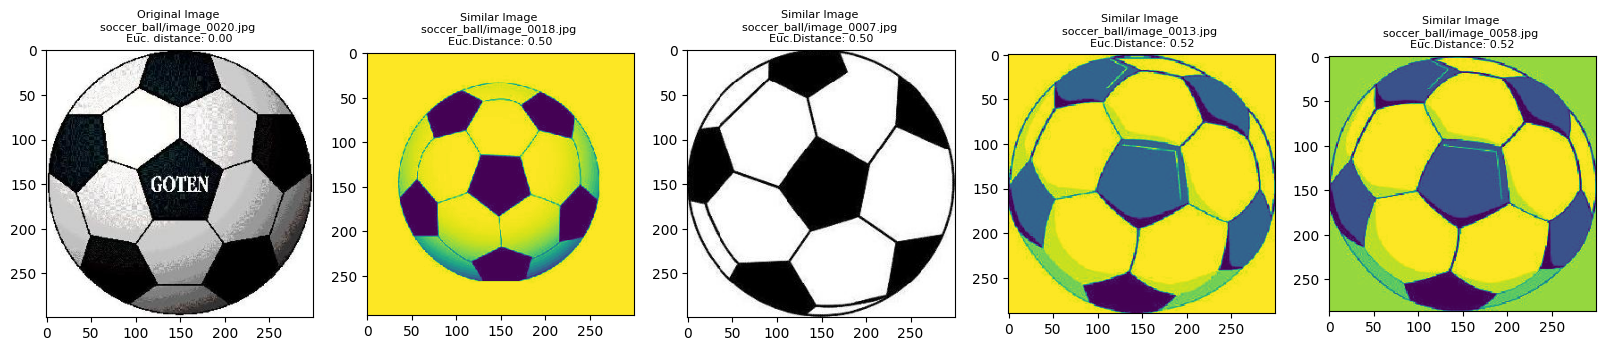

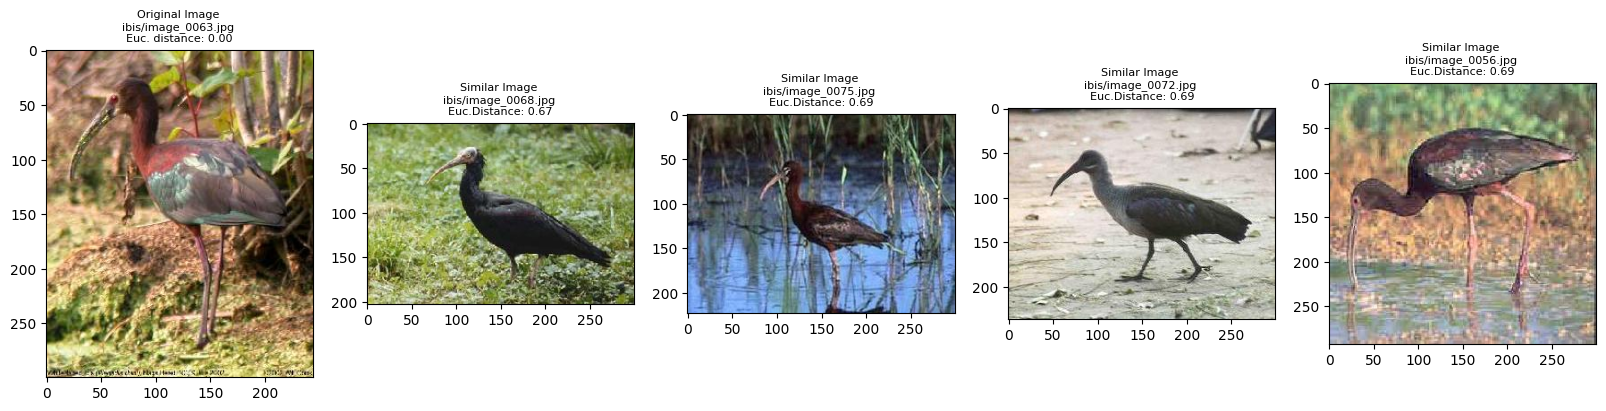

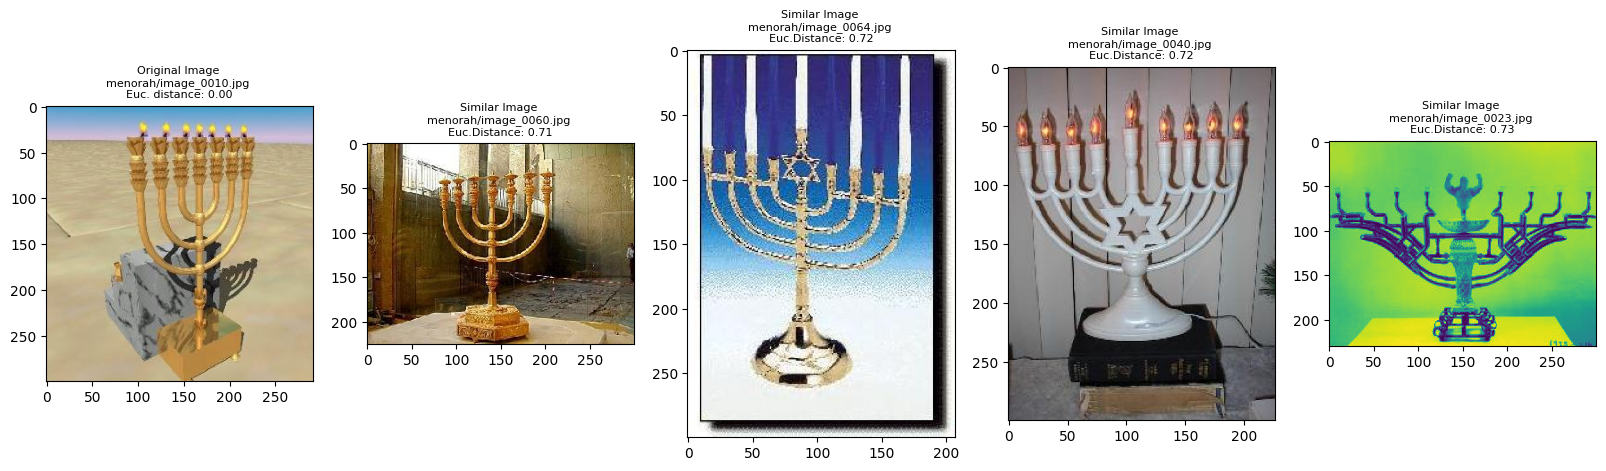

In [17]:
import random
quaries = 5
for i in range(quaries + 1):
  random_image_index = random.randint(0, len(filenames))
  plot_nearest_images(random_image_index)


### Visualizing Image Clusers with t-SNE


In [23]:
datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)

root_directory = '/content/caltech101/101_ObjectCategories'
generator = datagen.flow_from_directory(root_directory,
                                        target_size=(224, 224),
                                        class_mode=None,
                                        shuffle=False)
pickle.dump(generator.classes, open('data/class_ids-caltech101.pickle', 'wb'))

Found 8677 images belonging to 101 classes.


In [24]:
class_ids = pickle.load(open('data/class_ids-caltech101.pickle', 'rb'))

### We'll apply tSNE (t-distributed Stochastic Neighbor Embedding) to the reduced dimension feature_list (half of the feature list).

Here is the Detailed 🔗[**article about tSNE**](https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a)

In [29]:
# PCA and t-SNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

num_feature_dimensions = 100
pca = PCA(n_components=num_feature_dimensions)
pca.fit(feature_list)
feature_list_compressed = pca.transform(feature_list)

# for speed and ease of computation we'll analyse half of the dataset
selected_features = feature_list_compressed[:4000]
selected_filenames = filenames[:4000]
selected_class_ids = class_ids[:4000]

tsne_results = TSNE(n_components=2, verbose=2, metric='euclidean').fit_transform(selected_features)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.001s...
[t-SNE] Computed neighbors for 4000 samples in 0.308s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.143908
[t-SNE] Computed conditional probabilities in 0.106s
[t-SNE] Iteration 50: error = 75.5817413, gradient norm = 0.0307091 (50 iterations in 1.551s)
[t-SNE] Iteration 100: error = 69.9434891, gradient norm = 0.0103837 (50 iterations in 1.065s)
[t-SNE] Iteration 150: error = 68.6572800, gradient norm = 0.0051613 (50 iterations in 1.026s)
[t-SNE] Iteration 200: error = 68.1341782, gradient norm = 0.0038611 (50 iterations in 1.009s)
[t-SNE] Iteration 250: error = 67.8398743, gradient norm = 0.0030568 (50 iterations in 0.987s)
[t-SNE] KL divergence after 250 iterati

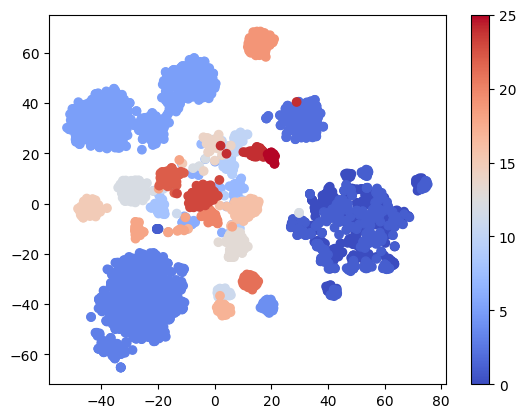

In [30]:
# colormap = plt.cm.get_cmap('coolwarm')
import matplotlib
colormap = matplotlib.colormaps['coolwarm']
scatter_plot = plt.scatter(tsne_results[:, 0],
                           tsne_results[:, 1],
                           c=selected_class_ids,
                           cmap=colormap)

plt.colorbar()
plt.show()